In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

**El conjunto de datos de salarios de puestos de ciencia de datos contiene 11 columnas, cada una con las siguientes características:**

- work_year: Año en que se pagó el salario.
- experience_level: Nivel de experiencia en el puesto durante el año.
- employment_type: Tipo de empleo para el puesto.
- job_title: Puesto desempeñado durante el año.
- salary: Salario bruto total pagado.
- salary_currency: Moneda del salario pagado, según el código ISO 4217.
- salaryinusd: Salario en USD.
- Employee_residence: País de residencia principal del empleado durante el año laboral, según el código ISO 3166.
- remote_ratio: Cantidad total de trabajo realizado de forma remota.
- company_location: País de la oficina principal o sucursal contratante del empleador.
- company_size: Mediana del número de personas que trabajaron para la empresa durante el año.

In [2]:
df = pd.read_csv('ds_salaries.csv')

In [4]:
# Exploratory Data Analysis (EDA)
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


In [ ]:
# Ver la dimensión del DataFrame
df.shape

(3755, 11)

In [8]:
# Verificando los tipos de datos y valores nulos
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

In [ ]:
# Si hay nulos en salary_in_usd
df[df['salary_in_usd'].isnull()]

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size


In [ ]:
# Presentan 1171 filas duplicadas
df.duplicated().sum()

np.int64(1171)

In [15]:
df = df.drop_duplicates()

Exploración básica

In [ ]:
# Salario promedio y máximo por nivel de experiencia
df.groupby('experience_level')['salary_in_usd'].agg(['mean', 'max', 'count']).round(2)

,mean,max,count
experience_level,,,
EN,72648.69,300000,270
EX,191078.21,416000,96
MI,101828.78,450000,664
SE,153897.44,423834,1554


In [47]:
# ¿Cuál es el salario promedio por experience_level?
df.groupby('experience_level')['salary_in_usd'].mean().reset_index().round(2)

,experience_level,salary_in_usd
0,EN,72648.69
1,EX,191078.21
2,MI,101828.78
3,SE,153897.44


In [46]:
# ¿Dónde pagan más? (por company_location)
df.groupby('company_location')['salary_in_usd'].mean().reset_index().sort_values(by='salary_in_usd', ascending=False).round(2).head(10)

,company_location,salary_in_usd
37,IL,271446.50
59,PR,167500.00
70,US,152374.79
62,RU,140333.33
12,CA,130572.76
55,NZ,125000.00
7,BA,120000.00
36,IE,114943.43
42,JP,114127.33
63,SE,105000.00


In [35]:
# Top 5 roles mejor pagados
df.groupby('job_title')['salary_in_usd'].mean().reset_index().sort_values(by='salary_in_usd', ascending=False).round(1).head()

,job_title,salary_in_usd
46,Data Science Tech Lead,375000.0
19,Cloud Data Architect,250000.0
35,Data Lead,212500.0
28,Data Analytics Lead,211254.5
84,Principal Data Scientist,198171.1


In [42]:
# ¿Influye trabajar remoto en el salario?
df.groupby('remote_ratio')['salary_in_usd'].mean().reset_index().sort_values(by='salary_in_usd', ascending=False).round(2)

,remote_ratio,salary_in_usd
0,0,143690.17
2,100,131821.67
1,50,78486.61


In [43]:
# ¿La empresa es grande o pequeña?
df.groupby('company_size')['salary_in_usd'].mean().reset_index().sort_values(by='salary_in_usd', ascending=False).round(2)

,company_size,salary_in_usd
1,M,141474.51
0,L,113202.24
2,S,78364.28


In [45]:
# Comparar salario local vs residencia del empleado
df['is_remote'] = df['employee_residence'] != df['company_location']
df.groupby('is_remote')['salary_in_usd'].mean().reset_index().rename(columns={'salary_in_usd': 'average_salary'}).round(2)

,is_remote,average_salary
0,False,135919.22
1,True,68359.99


Visualización

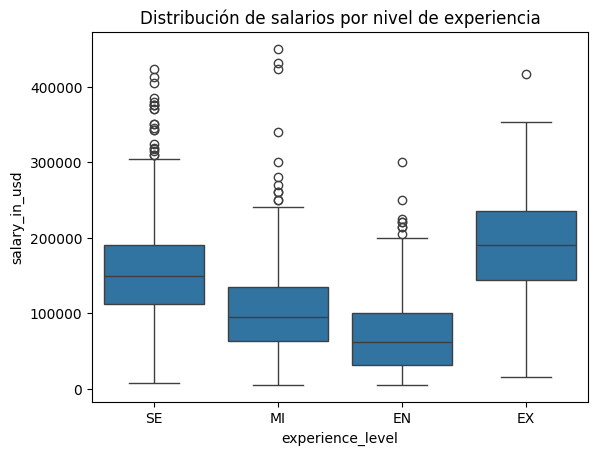

In [59]:
# Boxplot por nivel de experiencia
sns.boxplot(x='experience_level', y='salary_in_usd', data=df)
plt.title('Distribución de salarios por nivel de experiencia')
plt.show()

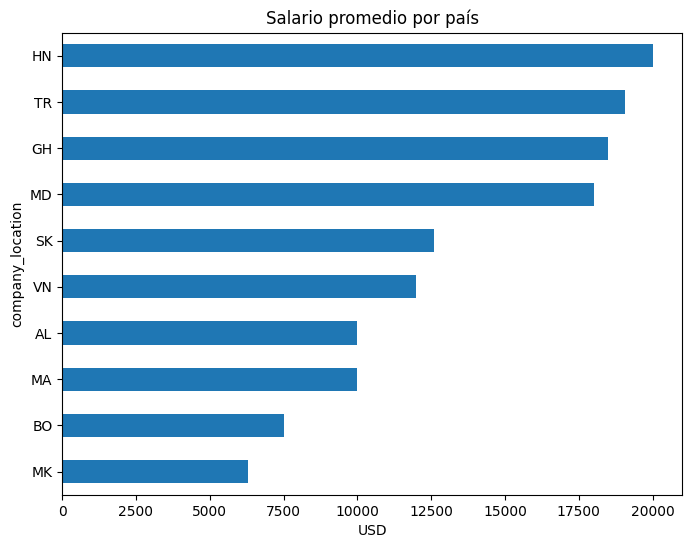

In [ ]:
# salario promedio por país
mean_salary_country = df.groupby('company_location')['salary_in_usd'].mean().sort_values().head(10)
mean_salary_country.plot(kind='barh', figsize=(8,6))
plt.title('Salario promedio por país')
plt.xlabel('USD')
plt.show()

In [67]:
df.corr(numeric_only=True)

,work_year,salary,salary_in_usd,remote_ratio,is_remote
work_year,1.000000,-0.099153,0.236958,-0.219160,-0.177300
salary,-0.099153,1.000000,-0.043672,0.026485,0.030217
salary_in_usd,0.236958,-0.043672,1.000000,-0.084502,-0.190360
remote_ratio,-0.219160,0.026485,-0.084502,1.000000,0.134000
is_remote,-0.177300,0.030217,-0.190360,0.134000,1.000000


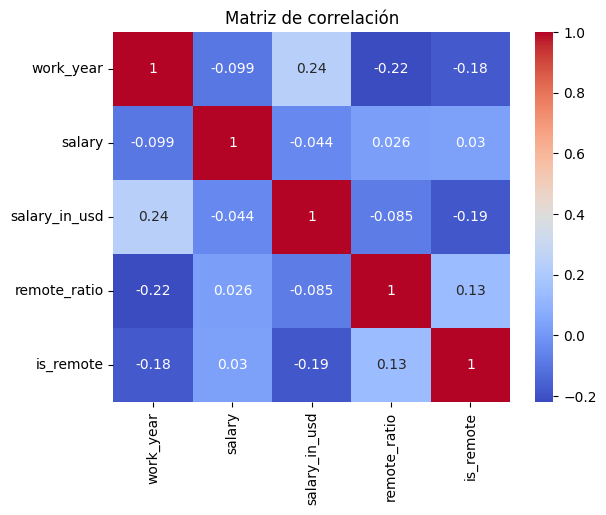

In [ ]:
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Matriz de correlación')
plt.show()

In [71]:
# Features
X = df[['experience_level', 'employment_type', 'job_title',
        'employee_residence', 'remote_ratio', 
        'company_location', 'company_size']]

y = df['salary_in_usd']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [ ]:
categorical_features = [
    'experience_level',
    'employment_type',
    'job_title',
    'employee_residence',
    'company_location',
    'company_size'
]

numerical_features = ['remote_ratio']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [76]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [77]:
model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [78]:
y_pred = model.predict(X_test)

print(f'MAE: {mean_absolute_error(y_test, y_pred):,.2f}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}')
print(f'R²: {r2_score(y_test, y_pred):.2f}')

MAE: 38,601.88
RMSE: 52109.33
R²: 0.38


In [79]:
sample = pd.DataFrame({
    'experience_level': ['SE'],
    'employment_type': ['FT'],
    'job_title': ['Data Scientist'],
    'employee_residence': ['CA'],
    'remote_ratio': [100],
    'company_location': ['CA'],
    'company_size': ['M']
})

salary_pred = model.predict(sample)
print(f'Salario estimado en USD: ${salary_pred[0]:,.2f}')

Salario estimado en USD: $149,690.72
